In [1]:
import copy
from dataclasses import dataclass
import datetime
import typing as T

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests
import seaborn as sns

from IPython.display import display
import ipywidgets as widgets

## Setup

In [2]:
from_date = widgets.DatePicker()
to_date = widgets.DatePicker()
print('From date:')
display(from_date)
print('To date:')
display(to_date)

From date:


DatePicker(value=None)

To date:


DatePicker(value=None)

## Visualisation & utility functions

In [3]:
def pivot_to_hm(df):
    dates = sorted(df.dt.unique())
    df_hm = pd.DataFrame(index=sorted(df.h.unique()))
    for date in dates:
        dt_col = pd.to_datetime(date).date().isoformat().replace('-', '_')
        df_sub = df[df.dt == date].set_index('h').SpotPriceDKK.to_frame(dt_col)
        df_sub[dt_col] = df_sub[dt_col] / 1000.0
        df_hm = df_hm.join(df_sub)
    return df_hm

In [4]:
def spot_heatmap(df, annot=True):
    df_plot = pivot_to_hm(df)
    sns.heatmap(df_plot, annot=annot, cmap='RdYlGn_r', fmt='.3g')
    plt.show()

## Load data

In [5]:
#df = download_nordpool_data(from_date.value, to_date.value)
#df.to_csv('../data/nordpool_2022_Q3.csv', index=False)
df = pd.read_csv('../data/nordpool_2022_Q3.csv', parse_dates=['HourUTC', 'HourDK', 'dt'])
#df.HourUTC = pd.to_datetime(df.HourUTC)
#df.HourDK = pd.to_datetime(df.HourDK)
#df.dt = pd.to_datetime(df.dt).dt.date
df.head()

,HourUTC,HourDK,PriceArea,SpotPriceDKK,SpotPriceEUR,dt,h
0,2022-09-29 21:00:00,2022-09-29 23:00:00,DK2,2784.679932,374.459991,2022-09-29,23
1,2022-09-29 20:00:00,2022-09-29 22:00:00,DK2,2952.530029,397.029999,2022-09-29,22
2,2022-09-29 19:00:00,2022-09-29 21:00:00,DK2,3160.449951,424.989990,2022-09-29,21
3,2022-09-29 18:00:00,2022-09-29 20:00:00,DK2,3867.000000,520.000000,2022-09-29,20
4,2022-09-29 17:00:00,2022-09-29 19:00:00,DK2,4499.100098,605.000000,2022-09-29,19


In [6]:
pivot_to_hm(df[df.dt > '2022-09-20'])

,2022_09_21,2022_09_22,2022_09_23,2022_09_24,2022_09_25,2022_09_26,2022_09_27,2022_09_28,2022_09_29
0,2.30756,2.77416,2.62164,2.81037,1.99775,1.84985,1.41990,2.27861,2.61357
1,2.22784,2.52387,2.38123,2.55889,1.71028,1.33736,1.34026,2.05076,2.50247
2,2.22754,2.45449,2.32435,2.32026,1.60052,1.16626,1.26263,1.82887,2.42535
3,2.22784,2.31216,2.23437,2.28457,1.59993,0.90154,1.12506,1.80686,2.34392
4,2.21074,2.39589,2.25400,2.27758,1.44555,0.73036,1.24441,2.03582,2.37969
5,2.53542,2.67697,2.41351,2.32554,1.46935,1.15942,1.56133,2.28389,2.56954
6,3.17548,3.23542,3.05367,2.56692,1.69644,1.81877,2.43513,2.84934,3.27259
7,3.97670,3.98594,3.38554,2.76457,1.78389,2.48280,3.09300,3.51459,4.23830
8,3.92434,3.70910,3.15711,2.75624,2.07271,2.45380,3.29793,3.72094,4.33877
9,3.17615,2.88429,2.79609,2.78963,2.16833,2.16759,3.06578,3.19691,3.55615


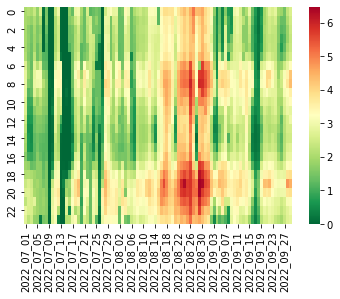

In [7]:
spot_heatmap(df, annot=False)

## Classes

### Battery

In [136]:
@dataclass
class BatteryState:
    # cost (depreciation) to charge 1 kWh
    depreciation_per_kWh: float = .3
    # charge remaining in battery
    remaining_kWh: float  = 0.0
    # maximum capacity in kWh
    capacity_kWh: float  = 5.0
    # maximum kWh charged per hour
    max_charge_kWh: float = 1
    # percentage lost in conversion
    loss_pct: float = 0.07

@dataclass
class Charge:
    charged_kWh: float
    consumed_kWh: float
    cost: float

@dataclass
class SimpleBattery:
    
    state: BatteryState = BatteryState()

    def charge(self, percentage, grid_kWh=np.inf):
        """
        charge the battery for one time unit
        """
        assert -1 <= percentage <= 1
        slack_kWh = self.state.capacity_kWh - self.state.remaining_kWh
        
        # cannot charge/discharge more than grid can receive/deliver
        # cannot charge more than slack x loss
        consumed_kWh = min(
            self.state.max_charge_kWh, 
            grid_kWh, 
            slack_kWh*(1+self.state.loss_pct)
        ) * percentage

        # lost to conversion
        charged_kWh = consumed_kWh * (1-self.loss_pct)
        
        # wear and tear on battery from charging
        cost = abs(consumed_kWh)*self.state.depreciation_per_kWh
        
        # 0 < remaining < capacity
        updated_kWh = self.state.remaining_kWh + charged_kWh
        self.state.remaining_kWh = min(self.state.capacity_kWh, max(0, updated_kWh))

        return Charge(charged_kWh=charged_kWh, consumed_kWh=consumed_kWh, cost=cost)
    
    def get_state(self):
        return copy.deepcopy(self.state)

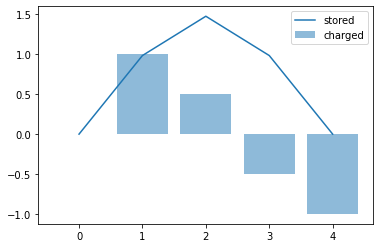

In [119]:
bat = SimpleBattery(loss_pct=0.015)
charges = [0, 1, .5, -.5, -1]
remaining = []

for pct in charges:
    bat.charge(pct)
    remaining.append(bat.remaining_kWh)

n = len(charges)
plt.bar(range(n), charges, label='charged', alpha=0.5)
plt.plot(range(n), remaining, label='stored')
plt.legend()

### Market

In [66]:
@dataclass
class MarketState:
    price_area: int
    ts: np.datetime64
    spot_dkk: float
    past_spot_dkk: np.ndarray
    past_ts: np.ndarray
    future_spot_dkk: np.ndarray
    future_ts: np.ndarray
        
        
def download_nordpool_data(from_date, to_date, price_area='DK2'):
    url = (
            f"https://api.energidataservice.dk/dataset/Elspotprices/download?"
            f"format=XL&offset=0&start={from_date}T00:00&end={to_date}T00:00"
            f"&filter=%7B%22PriceArea%22:%22{price_area}%22%7D&sort=HourDK%20DESC&timezone=dk"
    )
    df = pd.read_excel(url)
    df['dt'] = df.HourDK.dt.date
    df['h'] = df.HourDK.dt.hour
    return df


def market_windows(df, past_window=7*24, future_window=24, ceil=False):
    df = df.copy()
    area_groups = df.groupby('PriceArea')
    for price_area, g in area_groups:
        g = g.sort_values(by='HourDK')
        n = len(g) - (past_window + future_window) + 1
        for i in range(n):
            now = i+past_window
            t0 = now-past_window
            t1 = now+future_window
            past = g.iloc[t0:now]
            current_ts = g.iloc[now, :].HourDK.to_pydatetime()
            if ceil:
                t1 += 24-current_ts.hour
            future = g.iloc[now: t1]
            yield MarketState(
                price_area=price_area,
                spot_dkk=future.SpotPriceDKK.values[0],
                ts=current_ts,
                past_spot_dkk=past.SpotPriceDKK.values,
                past_ts=[pd.to_datetime(t) for t in past.HourDK.values],
                future_spot_dkk=future.SpotPriceDKK.values,
                future_ts=[pd.to_datetime(t) for t in future.HourDK.values],
            )

## Simulation

## Optimisation approach

In [132]:
def random_policy(market_state: MarketState, battery_state: BatteryState):
    n = len(market.future_ts)
    return np.random.uniform(low=-1, high=1, size=n)

def greedy_policy(market_state: MarketState, battery_state: BatteryState):
    n = len(market.future_ts)
    return [1 for _ in range(n)]

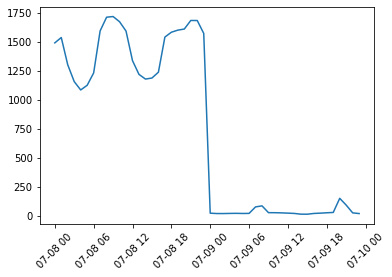

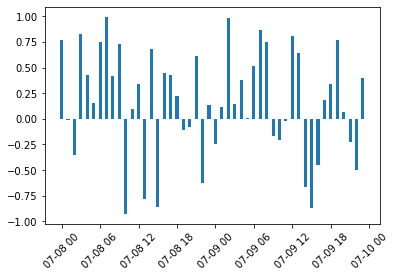

In [138]:
market_state = next(market_windows(df, ceil=True))
battery_state = SimpleBattery().get_state()

charges = random_policy(market_state, battery_state)

plt.plot(market_state.future_ts, market_state.future_spot_dkk)
plt.xticks(rotation=45)
plt.show()

plt.bar(market_state.future_ts, charges, width=0.02, label='charged')
plt.xticks(rotation=45)
plt.show()

## Reinforcement Learning approach

### Environment

In [67]:
@dataclass
class EnvironmentState:
    done: bool
    reward: float
    battery_state: SimpleBattery
    market_state: MarketState


class Environment:
    
    def __init__(self, battery, nordpool_df, past_window=7, future_window=2):
        self._battery_reset = copy.deepcopy(battery)
        self._battery = None
        self._nordpool_df = nordpool_df.copy()
        self._gen = None
        self._past_window = past_window
        self._future_window = future_window
    
    def reset(self):
        self._battery =  copy.deepcopy(self._battery_reset)
        self._gen = market_windows(
            self._nordpool_df,
            past_window = self._past_window,
            future_window = self._future_window,   
        )
        return self.step(0)

        
    def step(self, action: float):
        try:
            market_state = next(self._gen)
            return EnvironmentState(
                done=False,
                reward=0.0,
                battery_state=BatteryState(),
                market_state=market_state
            )
        except StopIteration:
            return EnvironmentState(
                done=True,
                reward=0.0,
                battery_state=None,
                market_state=None,
            )
        except Exception as e:
            print(e) # or whatever kind of logging you want

Total reward = 0.0


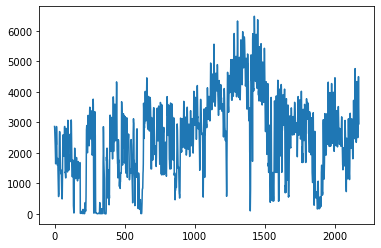

In [68]:
env = Environment(battery=SimpleBattery(), nordpool_df=df)
state = env.reset()
total_reward = 0
spot_dkk = []
while not state.done:
    state = env.step(0.5)
    total_reward += state.reward
    if state.market_state is not None: 
        spot_dkk.append(state.market_state.spot_dkk)
print(f'Total reward = {total_reward}')
plt.plot(spot_dkk)